<a href="https://colab.research.google.com/github/Nambu89/TFM_DSMARKET_24/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importamos las librerías

In [4]:
pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 21.3 MB/s eta 0:00:00


In [187]:
pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.3 MB/s eta 0:00:00


In [216]:
pip install --upgrade lightgbm

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from math import sqrt
import warnings
import statsmodels.api as sm
import time
import datetime
from datetime import datetime
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df1 = pd.read_csv('/content/drive/MyDrive/Master/TFM/clustered_data (1).csv')
df2 = pd.read_csv('/content/drive/MyDrive/Master/TFM/df_final2.csv')

In [9]:
df1.columns

Index(['item', 'mean_sales', 'total_sales', 'mean_price', 'min_price',
       'max_price', 'max_revenue', 'min_revenue', 'mean_revenue',
       'total_revenue', 'max_sales_per_week', 'mean_days_since_last_sale',
       'min_days_since_last_sale', 'max_days_since_last_sale',
       'mean_days_since_last_event', 'min_days_since_last_event',
       'max_days_since_last_event', 'clusters'],
      dtype='object')

In [10]:
df2.columns

Index(['id', 'item', 'category', 'department', 'store', 'store_code', 'region',
       'units_sold', 'date', 'weekday', 'week', 'event', 'sell_price',
       'yearweek', 'revenue', 'season', 'days_since_last_event',
       'days_since_last_sale'],
      dtype='object')

In [11]:
unique_items_df1 = df1['item'].nunique()
unique_items_df2 = df2['item'].nunique()
print("Valores únicos en df1 'item':", unique_items_df1)
print("Valores únicos en df2 'item':", unique_items_df2)

Valores únicos en df1 'item': 3049
Valores únicos en df2 'item': 3049


In [12]:
items_df1 = set(df1['item'].unique())
items_df2 = set(df2['item'].unique())

# Verificar si todos los items en df1 están en df2 y viceversa
print("Ítems en df1 no en df2:", items_df1 - items_df2)
print("Ítems en df2 no en df1:", items_df2 - items_df1)

Ítems en df1 no en df2: set()
Ítems en df2 no en df1: set()


In [71]:
# Convertimos la columna 'date' a datetime en df2 si aún no lo está
df2['date'] = pd.to_datetime(df2['date'])

In [72]:
# Resetear el índice de df2 para conservar la columna 'date' durante el merge
df2_reduced = df2[['item', 'department', 'store', 'store_code', 'region', 'date', 'id', 'sell_price', 'units_sold']]

In [73]:
# Unimos df1 y df2 basándonos en la columna 'item'
# Esto asume que 'item' es la clave adecuada para unirlos. Ajustamos según sea necesario.
df3 = pd.merge(df1, df2_reduced, on='item', how='left')

In [74]:
unique_items_df3 = df3['item'].nunique()
print("Valores únicos en df3 'item' después de la fusión:", unique_items_df3)

Valores únicos en df3 'item' después de la fusión: 3049


In [76]:
df3.columns

Index(['item', 'mean_sales', 'total_sales', 'mean_price', 'min_price',
       'max_price', 'max_revenue', 'min_revenue', 'mean_revenue',
       'total_revenue', 'max_sales_per_week', 'mean_days_since_last_sale',
       'min_days_since_last_sale', 'max_days_since_last_sale',
       'mean_days_since_last_event', 'min_days_since_last_event',
       'max_days_since_last_event', 'clusters', 'department', 'store',
       'store_code', 'region', 'date', 'id', 'sell_price', 'units_sold'],
      dtype='object')

In [77]:
# Restableces el índice para convertir 'date' en una columna
df3_reset = df3.reset_index()

# Buscas duplicados en df3_reset donde 'date' es ahora una columna accesible
duplicated_rows = df3_reset[df3_reset.duplicated(['item', 'id', 'date'], keep='first')]
print("Número de duplicados encontrados después de la fusión:", duplicated_rows.shape[0])


Número de duplicados encontrados después de la fusión: 0


In [78]:
# Establecemos 'date' como índice en df1
df3.set_index('date', inplace=True)

In [79]:
# Ordenamos el índice
df3.sort_index(inplace=True)

In [80]:
df3.columns

Index(['item', 'mean_sales', 'total_sales', 'mean_price', 'min_price',
       'max_price', 'max_revenue', 'min_revenue', 'mean_revenue',
       'total_revenue', 'max_sales_per_week', 'mean_days_since_last_sale',
       'min_days_since_last_sale', 'max_days_since_last_sale',
       'mean_days_since_last_event', 'min_days_since_last_event',
       'max_days_since_last_event', 'clusters', 'department', 'store',
       'store_code', 'region', 'id', 'sell_price', 'units_sold'],
      dtype='object')

In [83]:
df3.head()

,item,mean_sales,total_sales,mean_price,min_price,max_price,max_revenue,min_revenue,mean_revenue,total_revenue,...,min_days_since_last_event,max_days_since_last_event,clusters,department,store,store_code,region,id,sell_price,units_sold
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,ACCESORIES_1_001,0.213957,4093,11.468001,6.65,12.74,65.94,0.0,2.354289,45037.55,...,0.0,385.0,0,ACCESORIES_1,South_End,BOS_1,Boston,ACCESORIES_1_001_BOS_1,12.74,0
2011-01-29,SUPERMARKET_2_213,0.253267,4845,4.554900,3.00,5.35,62.70,0.0,1.188361,22733.34,...,0.0,385.0,3,SUPERMARKET_2,Roxbury,BOS_2,Boston,SUPERMARKET_2_213_BOS_2,4.18,0
2011-01-29,ACCESORIES_1_037,0.731783,13999,17.140080,15.80,17.93,186.78,0.0,12.544240,239971.32,...,0.0,385.0,0,ACCESORIES_1,Brooklyn,NYC_4,New York,ACCESORIES_1_037_NYC_4,17.25,0
2011-01-29,SUPERMARKET_2_213,0.253267,4845,4.554900,3.00,5.35,62.70,0.0,1.188361,22733.34,...,0.0,385.0,3,SUPERMARKET_2,South_End,BOS_1,Boston,SUPERMARKET_2_213_BOS_1,4.18,0
2011-01-29,SUPERMARKET_2_212,1.354731,25916,5.694409,4.54,7.16,191.73,0.0,7.208500,137898.60,...,0.0,385.0,3,SUPERMARKET_2,Queen_Village,PHI_3,Philadelphia,SUPERMARKET_2_212_PHI_3,5.02,3


In [85]:
df3.shape

(58327370, 25)

In [86]:
df3_agg = df3.groupby(['store_code', 'id']).agg({'total_revenue':np.sum})

In [87]:
g = df3_agg['total_revenue'].groupby('store_code', group_keys = False)

In [88]:
len(list(df3_agg.reset_index()['id']))

30490

In [89]:
top_items = list(df3_agg.reset_index()['id'])
top_items

['ACCESORIES_1_001_BOS_1',
 'ACCESORIES_1_002_BOS_1',
 'ACCESORIES_1_003_BOS_1',
 'ACCESORIES_1_004_BOS_1',
 'ACCESORIES_1_005_BOS_1',
 'ACCESORIES_1_006_BOS_1',
 'ACCESORIES_1_007_BOS_1',
 'ACCESORIES_1_008_BOS_1',
 'ACCESORIES_1_009_BOS_1',
 'ACCESORIES_1_010_BOS_1',
 'ACCESORIES_1_011_BOS_1',
 'ACCESORIES_1_012_BOS_1',
 'ACCESORIES_1_013_BOS_1',
 'ACCESORIES_1_014_BOS_1',
 'ACCESORIES_1_015_BOS_1',
 'ACCESORIES_1_016_BOS_1',
 'ACCESORIES_1_017_BOS_1',
 'ACCESORIES_1_018_BOS_1',
 'ACCESORIES_1_019_BOS_1',
 'ACCESORIES_1_020_BOS_1',
 'ACCESORIES_1_021_BOS_1',
 'ACCESORIES_1_022_BOS_1',
 'ACCESORIES_1_023_BOS_1',
 'ACCESORIES_1_024_BOS_1',
 'ACCESORIES_1_025_BOS_1',
 'ACCESORIES_1_026_BOS_1',
 'ACCESORIES_1_027_BOS_1',
 'ACCESORIES_1_028_BOS_1',
 'ACCESORIES_1_029_BOS_1',
 'ACCESORIES_1_030_BOS_1',
 'ACCESORIES_1_031_BOS_1',
 'ACCESORIES_1_032_BOS_1',
 'ACCESORIES_1_033_BOS_1',
 'ACCESORIES_1_034_BOS_1',
 'ACCESORIES_1_035_BOS_1',
 'ACCESORIES_1_036_BOS_1',
 'ACCESORIES_1_037_BOS_1',
 

In [90]:
df3_filtered = df3[df3['id'].isin(top_items)]

In [91]:
df3_filtered

,item,mean_sales,total_sales,mean_price,min_price,max_price,max_revenue,min_revenue,mean_revenue,total_revenue,...,min_days_since_last_event,max_days_since_last_event,clusters,department,store,store_code,region,id,sell_price,units_sold
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,ACCESORIES_1_001,0.213957,4093,11.468001,6.65,12.74,65.94,0.0,2.354289,45037.55,...,0.0,385.0,0,ACCESORIES_1,South_End,BOS_1,Boston,ACCESORIES_1_001_BOS_1,12.74,0
2011-01-29,SUPERMARKET_2_213,0.253267,4845,4.554900,3.00,5.35,62.70,0.0,1.188361,22733.34,...,0.0,385.0,3,SUPERMARKET_2,Roxbury,BOS_2,Boston,SUPERMARKET_2_213_BOS_2,4.18,0
2011-01-29,ACCESORIES_1_037,0.731783,13999,17.140080,15.80,17.93,186.78,0.0,12.544240,239971.32,...,0.0,385.0,0,ACCESORIES_1,Brooklyn,NYC_4,New York,ACCESORIES_1_037_NYC_4,17.25,0
2011-01-29,SUPERMARKET_2_213,0.253267,4845,4.554900,3.00,5.35,62.70,0.0,1.188361,22733.34,...,0.0,385.0,3,SUPERMARKET_2,South_End,BOS_1,Boston,SUPERMARKET_2_213_BOS_1,4.18,0
2011-01-29,SUPERMARKET_2_212,1.354731,25916,5.694409,4.54,7.16,191.73,0.0,7.208500,137898.60,...,0.0,385.0,3,SUPERMARKET_2,Queen_Village,PHI_3,Philadelphia,SUPERMARKET_2_212_PHI_3,5.02,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,SUPERMARKET_2_206,0.261997,5012,12.768164,9.58,13.85,197.70,0.0,3.316971,63453.65,...,0.0,385.0,0,SUPERMARKET_2,South_End,BOS_1,Boston,SUPERMARKET_2_206_BOS_1,11.98,0
2016-04-24,SUPERMARKET_2_206,0.261997,5012,12.768164,9.58,13.85,197.70,0.0,3.316971,63453.65,...,0.0,385.0,0,SUPERMARKET_2,Roxbury,BOS_2,Boston,SUPERMARKET_2_206_BOS_2,11.98,5
2016-04-24,SUPERMARKET_2_206,0.261997,5012,12.768164,9.58,13.85,197.70,0.0,3.316971,63453.65,...,0.0,385.0,0,SUPERMARKET_2,Back_Bay,BOS_3,Boston,SUPERMARKET_2_206_BOS_3,11.98,0


In [93]:
df3_filtered.columns

Index(['item', 'mean_sales', 'total_sales', 'mean_price', 'min_price',
       'max_price', 'max_revenue', 'min_revenue', 'mean_revenue',
       'total_revenue', 'max_sales_per_week', 'mean_days_since_last_sale',
       'min_days_since_last_sale', 'max_days_since_last_sale',
       'mean_days_since_last_event', 'min_days_since_last_event',
       'max_days_since_last_event', 'clusters', 'department', 'store',
       'store_code', 'region', 'id', 'sell_price', 'units_sold'],
      dtype='object')

In [95]:
# Seleccionar solo las columnas numéricas para calcular la correlación
df_numeric = df3_filtered.select_dtypes(include='number')

# Calcular la matriz de correlación entre las características numéricas y la variable objetivo ('total_sales')
correlation_with_sales = df_numeric.corr()['total_sales'].drop('total_sales')

# Definir un umbral para la correlación
umbral_correlacion = 0.05  # Puedes ajustar este valor según tu criterio

# Filtrar las características con baja correlación
caracteristicas_baja_correlacion = correlation_with_sales[abs(correlation_with_sales) < umbral_correlacion].index.tolist()

print("Características con baja correlación con 'total_sales':")
print(caracteristicas_baja_correlacion)

Características con baja correlación con 'total_sales':
[]


# Información por meses

In [96]:
# Iniciamos el cronómetro
st = time.time()

# Agrupamos por id y resampleamos las ventas a una base mensual
gb_df = df3_filtered.groupby('id').resample('M').agg(
    {'units_sold': 'sum',
    'sell_price': 'mean',
    'total_revenue': 'sum'
}). reset_index()

# Terminamos el cronómetro
et = time.time()

# Imprimimos el tiempo total de cálculo
print('Total time in minutes to process took {}'.format((et-st) / 60))

# Imprimimos las 5 primeras filas
gb_df.head(5)

Total time in minutes to process took 3.6391015450159707


,id,date,units_sold,sell_price,total_revenue
0,ACCESORIES_1_001_BOS_1,2011-01-31,0,12.74,135112.65
1,ACCESORIES_1_001_BOS_1,2011-02-28,0,12.74,1261051.40
2,ACCESORIES_1_001_BOS_1,2011-03-31,0,12.74,1396164.05
3,ACCESORIES_1_001_BOS_1,2011-04-30,0,12.74,1351126.50
4,ACCESORIES_1_001_BOS_1,2011-05-31,0,12.74,1396164.05


In [97]:
# Calculamos la fecha mínima en el DataFrame 'gb_df' para saber cuándo comienzan nuestros datos
min_date = gb_df["date"].min()

# Calculamos la fecha máxima en 'gb_df' para identificar hasta qué punto llegan nuestros datos
max_date_sales = gb_df["date"].max()

# Imprimimos la fecha mínima para tener una referencia clara del inicio de nuestros datos temporales
print(min_date)

# Imprimimos la fecha máxima para conocer el límite temporal de nuestros datos
print(max_date_sales)

2011-01-31 00:00:00
2016-04-30 00:00:00


In [98]:
gb_df['date'].nunique()

64

In [99]:
# Usamos esta fecha como máximo porque es el mes que queremos predecir
max_date_test = datetime(2016,5,31)

In [100]:
date_range = pd.date_range(min_date, max_date_test, freq='M')
print('We have a total of {} months'. format(len(date_range)))
date_range

We have a total of 65 months


DatetimeIndex(['2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
               '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-31',
               '2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
               '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
      

In [101]:
unique_id = gb_df['id'].unique()
len(unique_id)

30490

In [102]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ['date', 'id'])
len(cartesian_product)

1981850

In [103]:
print(len(cartesian_product) - gb_df.shape[0])
print((len(cartesian_product) - gb_df.shape[0]) / len(unique_id))

30490
1.0


# Unimos todas las tablas

In [104]:
f_df = pd.DataFrame(index = cartesian_product).reset_index()

f_df.head()

,date,id
0,2011-01-31,ACCESORIES_1_001_BOS_1
1,2011-01-31,ACCESORIES_1_001_BOS_2
2,2011-01-31,ACCESORIES_1_001_BOS_3
3,2011-01-31,ACCESORIES_1_001_NYC_1
4,2011-01-31,ACCESORIES_1_001_NYC_2


In [105]:
print(f_df.shape)

f_df = pd.merge (
    left = f_df,
    right = gb_df,
    on = ['date', 'id'],
    how = 'left'
)

print(f_df.shape)

(1981850, 2)
(1981850, 5)


In [106]:
f_df

,date,id,units_sold,sell_price,total_revenue
0,2011-01-31,ACCESORIES_1_001_BOS_1,0.0,12.74,135112.65
1,2011-01-31,ACCESORIES_1_001_BOS_2,0.0,12.74,135112.65
2,2011-01-31,ACCESORIES_1_001_BOS_3,0.0,11.46,135112.65
3,2011-01-31,ACCESORIES_1_001_NYC_1,0.0,12.74,135112.65
4,2011-01-31,ACCESORIES_1_001_NYC_2,0.0,10.99,135112.65
...,...,...,...,...,...
1981845,2016-05-31,SUPERMARKET_3_827_NYC_3,NaN,NaN,NaN
1981846,2016-05-31,SUPERMARKET_3_827_NYC_4,NaN,NaN,NaN
1981847,2016-05-31,SUPERMARKET_3_827_PHI_1,NaN,NaN,NaN
1981848,2016-05-31,SUPERMARKET_3_827_PHI_2,NaN,NaN,NaN


In [107]:
f_df.isnull().sum()

date                 0
id                   0
units_sold       30490
sell_price       30490
total_revenue    30490
dtype: int64

In [108]:
f_df[f_df['sell_price'].isnull()].sample(5)

,date,id,units_sold,sell_price,total_revenue
1952313,2016-05-31,ACCESORIES_1_099_NYC_1,NaN,NaN,NaN
1952167,2016-05-31,ACCESORIES_1_083_PHI_1,NaN,NaN,NaN
1967772,2016-05-31,SUPERMARKET_1_031_BOS_3,NaN,NaN,NaN
1966233,2016-05-31,HOME_&_GARDEN_2_392_NYC_1,NaN,NaN,NaN
1966412,2016-05-31,HOME_&_GARDEN_2_410_BOS_3,NaN,NaN,NaN


In [109]:
f_df['units_sold'].fillna(0, inplace = True)
f_df['total_revenue'].fillna(0, inplace = True)

In [112]:
print("Índice de la serie original:")
print(f_df['sell_price'].index)
print("Índice de la serie resultante de groupby:")
print(f_df.groupby('id')['sell_price'].apply(lambda series: series.backfill().ffill().reset_index(drop=True)).index)

Índice de la serie original:
RangeIndex(start=0, stop=1981850, step=1)
Índice de la serie resultante de groupby:
MultiIndex([( 'ACCESORIES_1_001_BOS_1',  0),
            ( 'ACCESORIES_1_001_BOS_1',  1),
            ( 'ACCESORIES_1_001_BOS_1',  2),
            ( 'ACCESORIES_1_001_BOS_1',  3),
            ( 'ACCESORIES_1_001_BOS_1',  4),
            ( 'ACCESORIES_1_001_BOS_1',  5),
            ( 'ACCESORIES_1_001_BOS_1',  6),
            ( 'ACCESORIES_1_001_BOS_1',  7),
            ( 'ACCESORIES_1_001_BOS_1',  8),
            ( 'ACCESORIES_1_001_BOS_1',  9),
            ...
            ('SUPERMARKET_3_827_PHI_3', 55),
            ('SUPERMARKET_3_827_PHI_3', 56),
            ('SUPERMARKET_3_827_PHI_3', 57),
            ('SUPERMARKET_3_827_PHI_3', 58),
            ('SUPERMARKET_3_827_PHI_3', 59),
            ('SUPERMARKET_3_827_PHI_3', 60),
            ('SUPERMARKET_3_827_PHI_3', 61),
            ('SUPERMARKET_3_827_PHI_3', 62),
            ('SUPERMARKET_3_827_PHI_3', 63),
            ('SU

In [113]:
print("Valores únicos de 'id' en la serie original:")
print(f_df['id'].unique())
print("Valores únicos de 'id' en la serie resultante de groupby:")
print(f_df.groupby('id')['sell_price'].apply(lambda series: series.backfill().ffill().reset_index(drop=True)).index.get_level_values('id').unique())

Valores únicos de 'id' en la serie original:
['ACCESORIES_1_001_BOS_1' 'ACCESORIES_1_001_BOS_2'
 'ACCESORIES_1_001_BOS_3' ... 'SUPERMARKET_3_827_PHI_1'
 'SUPERMARKET_3_827_PHI_2' 'SUPERMARKET_3_827_PHI_3']
Valores únicos de 'id' en la serie resultante de groupby:
Index(['ACCESORIES_1_001_BOS_1', 'ACCESORIES_1_001_BOS_2',
       'ACCESORIES_1_001_BOS_3', 'ACCESORIES_1_001_NYC_1',
       'ACCESORIES_1_001_NYC_2', 'ACCESORIES_1_001_NYC_3',
       'ACCESORIES_1_001_NYC_4', 'ACCESORIES_1_001_PHI_1',
       'ACCESORIES_1_001_PHI_2', 'ACCESORIES_1_001_PHI_3',
       ...
       'SUPERMARKET_3_827_BOS_1', 'SUPERMARKET_3_827_BOS_2',
       'SUPERMARKET_3_827_BOS_3', 'SUPERMARKET_3_827_NYC_1',
       'SUPERMARKET_3_827_NYC_2', 'SUPERMARKET_3_827_NYC_3',
       'SUPERMARKET_3_827_NYC_4', 'SUPERMARKET_3_827_PHI_1',
       'SUPERMARKET_3_827_PHI_2', 'SUPERMARKET_3_827_PHI_3'],
      dtype='object', name='id', length=30490)


In [114]:
print("Datos faltantes en la serie original:")
print(f_df['sell_price'].isnull().sum())
print("Datos faltantes en la serie resultante de groupby:")
print(f_df.groupby('id')['sell_price'].apply(lambda series: series.backfill().ffill().reset_index(drop=True)).isnull().sum())

Datos faltantes en la serie original:
30490
Datos faltantes en la serie resultante de groupby:
0


In [121]:
# Convertir el índice de la serie original en un índice multi-nivel con los mismos valores que el índice de la serie resultante de groupby
f_df['sell_price'].index = pd.MultiIndex.from_tuples([(id_, i) for id_, i in zip(f_df['id'], range(len(f_df)))], names=['id', None])

In [123]:
f_df['id'] = f_df['id'].astype(str)  # Por ejemplo, convertir a string si es necesario

In [124]:
f_df["sell_price"] = f_df.groupby("id")["sell_price"].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

In [125]:
f_df.isnull().sum()

date             0
id               0
units_sold       0
sell_price       0
total_revenue    0
dtype: int64

In [127]:
# En esta celda, estamos revisando las dimensiones de nuestro DataFrame filtrado para entender el alcance de los datos con los que trabajamos.
# Además, seleccionamos algunas variables clave que son importantes para nuestro análisis y proyecto de predicción de ventas,
# asegurándonos de eliminar cualquier duplicado para mantener la precisión y relevancia en nuestro análisis.

# Imprimimos las dimensiones del DataFrame para ver cuántas filas y columnas tenemos después de filtrar
print(df3_filtered.shape)

# Seleccionamos ciertas variables que serán adicionadas a nuestro análisis
# Estas variables incluyen identificadores y categorías que son esenciales para un análisis detallado y preciso
vars_to_add = df3_filtered[
    ["item", "department", "store", "store_code", "region", "id"]
].drop_duplicates()  # Eliminamos duplicados para asegurarnos de que cada combinación de estas variables es única

# Imprimimos las dimensiones del nuevo DataFrame para verificar cuántos registros únicos tenemos
print(vars_to_add.shape)

(58327370, 25)
(30490, 6)


In [128]:
print(f_df.shape)
f_df = pd.merge(
    left = f_df,
    right = vars_to_add,
    on = ['id'],
    how = 'left'
)

print(f_df.shape)

(1981850, 5)
(1981850, 10)


In [129]:
f_df.columns

Index(['date', 'id', 'units_sold', 'sell_price', 'total_revenue', 'item',
       'department', 'store', 'store_code', 'region'],
      dtype='object')

In [131]:
class FeatureGenerator(object):
    '''
    Esta clase ayuda a enriquecer un DataFrame con nuevas características estadísticas y temporales,
    las cuales son críticas para mejorar la precisión de los modelos de predicción de ventas.
    '''

    def __init__(self, full_df, gb_list):
        '''
        Inicializa la clase con un DataFrame y una lista de columnas para agrupar.
        '''
        self.full_df = full_df
        self.gb_list = gb_list
        self.objective_column_name = "_".join(gb_list)

    def generate_gb_df(self):
        '''
        Agrupa el DataFrame original y calcula sumas y medias de 'units_sold' por cada grupo.
        El resultado es un DataFrame con características agregadas que pueden ayudar a identificar tendencias.
        '''
        def my_agg(full_df_, args):
            names = {
                '{}_sum'.format(args): full_df_['units_sold'].sum(),
                '{}_mean'.format(args): full_df_['units_sold'].mean(),
            }
            return pd.Series(names, index=[key for key in names.keys()])

        gb_df_ = self.full_df.groupby(self.gb_list).apply(my_agg, args=(self.objective_column_name)).reset_index()
        self.gb_df_ = gb_df_

    def return_gb_df(self):
        '''
        Crea características de retraso y variación para cada característica agregada, que son esenciales
        para modelos que necesitan entender cómo cambian las ventas con el tiempo.
        '''
        def generate_shift_features(self, suffix):
            name_ = self.objective_column_name + "_" + suffix

            for i in range(1, 4):
                self.gb_df_['{}_shift_{}'.format(name_, i)] =\
                self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: series.shift(i))

                if i < 4:
                    self.gb_df_['{}_var_pct_{}'.format(name_, i)] =\
                    self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: (series - series.shift(i)) / series.shift(i))

            self.gb_df_.fillna(-1, inplace=True)
            self.gb_df_.replace([np.inf, -np.inf], -1, inplace=True)

        generate_shift_features(self, suffix="sum")
        generate_shift_features(self, suffix="mean")

        return self.gb_df_

# Ejemplo de uso
feature_gen = FeatureGenerator(f_df, ['date', 'store'])
feature_gen.generate_gb_df()
final_features_df = feature_gen.return_gb_df()
final_features_df.head()  # Muestra algunas de las características generadas


,date,store,date_store_sum,date_store_mean,date_store_sum_shift_1,date_store_sum_var_pct_1,date_store_sum_shift_2,date_store_sum_var_pct_2,date_store_sum_shift_3,date_store_sum_var_pct_3,date_store_mean_shift_1,date_store_mean_var_pct_1,date_store_mean_shift_2,date_store_mean_var_pct_2,date_store_mean_shift_3,date_store_mean_var_pct_3
0,2011-01-31,Back_Bay,8261.0,2.709413,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2011-01-31,Brooklyn,4788.0,1.570351,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2011-01-31,Greenwich_Village,11308.0,3.708757,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2011-01-31,Harlem,8661.0,2.840603,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2011-01-31,Midtown_Village,6460.0,2.118727,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [132]:
# En esta celda, vamos a generar características avanzadas para nuestro proyecto de predicción de ventas.
# Utilizamos la clase FeatureGenerator para crear sumas, medias, características de retraso y variaciones porcentuales.
# Medimos el tiempo de ejecución para evaluar la eficiencia de nuestro proceso de generación de características.

# Empezamos midiendo el tiempo de inicio
st = time.time()

# Definimos las columnas sobre las cuales queremos agrupar los datos
gb_list = ["date", "store", "region"]

# Creamos una instancia de FeatureGenerator con nuestro DataFrame f_df y la lista de columnas para agrupar
fe_generator = FeatureGenerator(full_df = f_df, gb_list = gb_list)

# Generamos el DataFrame agrupado con sumas y medias de 'units_sold'
fe_generator.generate_gb_df()

# Obtenemos el DataFrame con características adicionales como lags y cambios porcentuales
shop_sales_features = fe_generator.return_gb_df()

# Eliminamos la columna 'region' del DataFrame resultante, ya que no la necesitaremos más adelante
shop_sales_features.drop("region", axis = 1, inplace = True)

# Calculamos el tiempo de finalización y lo convertimos a minutos para entender la duración del proceso
et = time.time()
elapsed_time = (et - st) / 60

# Imprimimos el tiempo transcurrido para monitorear la eficiencia
print(f"Tiempo transcurrido: {elapsed_time} minutos")

# Mostramos las primeras filas del DataFrame resultante para verificar las nuevas características
shop_sales_features.head()

Tiempo transcurrido: 0.022857928276062013 minutos


,date,store,date_store_region_sum,date_store_region_mean,date_store_region_sum_shift_1,date_store_region_sum_var_pct_1,date_store_region_sum_shift_2,date_store_region_sum_var_pct_2,date_store_region_sum_shift_3,date_store_region_sum_var_pct_3,date_store_region_mean_shift_1,date_store_region_mean_var_pct_1,date_store_region_mean_shift_2,date_store_region_mean_var_pct_2,date_store_region_mean_shift_3,date_store_region_mean_var_pct_3
0,2011-01-31,Back_Bay,8261.0,2.709413,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2011-01-31,Brooklyn,4788.0,1.570351,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2011-01-31,Greenwich_Village,11308.0,3.708757,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2011-01-31,Harlem,8661.0,2.840603,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2011-01-31,Midtown_Village,6460.0,2.118727,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [133]:
shop_sales_features.shape

(650, 16)

In [134]:
# En esta celda, estamos enfocándonos en generar características avanzadas para las ventas mensuales por departamento.
# Utilizamos la clase FeatureGenerator para extraer sumas, medias y características dinámicas basadas en el tiempo.
# Además, medimos el tiempo de ejecución para evaluar la eficiencia del proceso de generación de características.

# Empezamos midiendo el tiempo de inicio
st = time.time()

# Definimos las columnas sobre las cuales queremos agrupar los datos, centrándonos en la fecha y el departamento
gb_list = ['date', 'department']

# Creamos una instancia de FeatureGenerator con nuestro DataFrame
fe_generator = FeatureGenerator(full_df = f_df, gb_list = gb_list)

# Generamos el DataFrame agrupado, calculando sumas y medias de 'units_sold' por cada combinación de fechas y departamentos
fe_generator.generate_gb_df()

# Obtenemos el DataFrame con características adicionales, que incluyen lags y variaciones porcentuales
month_item_department_features = fe_generator.return_gb_df()

# Calculamos el tiempo de finalización y lo convertimos a minutos para comprender la duración del proceso
et = time.time()
elapsed_time = (et - st) / 60

# Imprimimos el tiempo transcurrido para controlar la eficiencia de nuestra generación de características
print(f'Tiempo transcurrido: {elapsed_time} minutos')

# Mostramos las primeras filas del DataFrame resultante para revisar las características generadas
month_item_department_features.head()

Tiempo transcurrido: 0.012362082799275717 minutos


,date,department,date_department_sum,date_department_mean,date_department_sum_shift_1,date_department_sum_var_pct_1,date_department_sum_shift_2,date_department_sum_var_pct_2,date_department_sum_shift_3,date_department_sum_var_pct_3,date_department_mean_shift_1,date_department_mean_var_pct_1,date_department_mean_shift_2,date_department_mean_var_pct_2,date_department_mean_shift_3,date_department_mean_var_pct_3
0,2011-01-31,ACCESORIES_1,9279.0,2.230529,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2011-01-31,ACCESORIES_2,524.0,0.351678,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2011-01-31,HOME_&_GARDEN_1,10790.0,2.028195,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2011-01-31,HOME_&_GARDEN_2,4460.0,0.866019,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2011-01-31,SUPERMARKET_1,6216.0,2.877778,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [135]:
month_item_department_features.shape

(455, 16)

In [137]:
# En esta celda, nos enfocamos en generar características detalladas para las ventas mensuales por tienda.
# Utilizamos la clase FeatureGenerator para extraer sumas, medias y características dinámicas basadas en el tiempo,
# lo cual es vital para nuestros modelos de predicción. Además, medimos la duración del proceso para evaluar su eficiencia.

# Marcamos el tiempo de inicio para calcular la duración del proceso de generación de características
st = time.time()

# Especificamos las columnas que queremos utilizar para agrupar los datos en nuestro análisis
gb_list = ["date", "store"]

# Instanciamos FeatureGenerator con nuestro DataFrame f_df y la lista de columnas para el agrupamiento
fe_generator = FeatureGenerator(full_df = f_df, gb_list = gb_list)

# Generamos un DataFrame agrupado que calcula sumas y medias de 'units_sold' por cada combinación de fecha y tienda
fe_generator.generate_gb_df()

# Obtenemos el DataFrame resultante con características adicionales como lags y variaciones porcentuales
store_sales_features = fe_generator.return_gb_df()

# Medimos el tiempo de finalización del proceso
et = time.time()

# Calculamos y mostramos la duración del proceso en minutos para monitorear la eficiencia
elapsed_time = (et - st) / 60
print(f"Tiempo transcurrido: {elapsed_time} minutos")

# Mostramos las primeras filas del DataFrame generado para revisar las nuevas características
store_sales_features.head()

Tiempo transcurrido: 0.015880215167999267 minutos


,date,store,date_store_sum,date_store_mean,date_store_sum_shift_1,date_store_sum_var_pct_1,date_store_sum_shift_2,date_store_sum_var_pct_2,date_store_sum_shift_3,date_store_sum_var_pct_3,date_store_mean_shift_1,date_store_mean_var_pct_1,date_store_mean_shift_2,date_store_mean_var_pct_2,date_store_mean_shift_3,date_store_mean_var_pct_3
0,2011-01-31,Back_Bay,8261.0,2.709413,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2011-01-31,Brooklyn,4788.0,1.570351,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2011-01-31,Greenwich_Village,11308.0,3.708757,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2011-01-31,Harlem,8661.0,2.840603,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2011-01-31,Midtown_Village,6460.0,2.118727,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [143]:
print("Shape before merge is {}".format(f_df.shape))

full_df = f_df.copy()

# Realizamos las fusiones en 'full_df'
full_df = pd.merge(full_df, shop_sales_features, on=["date", "store"], how="left")
full_df = pd.merge(full_df, month_item_department_features, on=["date", "department"], how="left")
full_df = pd.merge(full_df, store_sales_features, on=["date", "store"], how="left")

# Renombramos una columna si es necesario
if "item_cnt_day" in full_df.columns:
    full_df.rename(columns={"item_cnt_day": "sales"}, inplace=True)

# Verificamos el tamaño de 'full_df' después de las fusiones
"Shape after merge is {}".format(full_df.shape)

Shape before merge is (1981850, 24)


'Shape after merge is (1981850, 66)'

In [155]:
# En esta celda, nos enfocamos en preparar nuestro DataFrame para el modelado, eliminando las filas
# donde las características de retraso aún no están disponibles. Este paso es crucial para garantizar que nuestros modelos de predicción trabajen con datos completos y precisos.

# Convertimos la columna 'date' a tipo datetime si aún no se ha hecho, para asegurar una comparación adecuada
full_df['date'] = pd.to_datetime(full_df['date'])

# Filtramos el DataFrame para incluir solo las filas desde junio de 2011 en adelante.
# Elegimos esta fecha porque asumimos que es el punto a partir del cual todas nuestras características de retraso están completas y utilizables para el modelado.
full_df_model = full_df[full_df['date'] > np.datetime64('2011-05-31')]

print(type(full_df_model))

# Verificamos la forma del DataFrame filtrado para entender cuántas filas y columnas estamos manejando ahora
print('Shape of DataFrame after filtering is {}'. format(full_df.shape))

<class 'pandas.core.frame.DataFrame'>
Shape of DataFrame after filtering is (1981850, 66)


In [156]:
# En esta celda, vamos a eliminar columnas que no son necesarias para nuestro modelado posterior.
# Este paso es importante para simplificar nuestro DataFrame y enfocarnos solo en las características que realmente contribuyen a la predicción de ventas, mejorando así la eficiencia de nuestros modelos.
if isinstance(full_df_model, pd.DataFrame):
    # Lista de columnas que consideramos no esenciales para el modelado
    cols_to_drop = ['item', 'department', 'store', 'store_code', 'region']

    # Eliminamos las columnas no deseadas de nuestro DataFrame
    full_df_model.drop(cols_to_drop, inplace=True, axis=1)

    # Verificamos la forma del DataFrame después de eliminar las columnas para confirmar los cambios
    print("Shape of DataFrame after dropping columns is {}".format(full_df_model.shape))
else:
    print("Error: full_df_model is not a DataFrame.")

Shape of DataFrame after dropping columns is (1829400, 61)


In [157]:
full_df_model.reset_index(drop = True, inplace = True)
full_df_model

,date,id,units_sold,sell_price,total_revenue,date_store_sum_x,date_store_mean_x,date_store_sum_shift_1_x,date_store_sum_var_pct_1_x,date_store_sum_shift_2_x,...,date_store_sum_shift_2_y,date_store_sum_var_pct_2_y,date_store_sum_shift_3_y,date_store_sum_var_pct_3_y,date_store_mean_shift_1_y,date_store_mean_var_pct_1_y,date_store_mean_shift_2_y,date_store_mean_var_pct_2_y,date_store_mean_shift_3_y,date_store_mean_var_pct_3_y
0,2011-06-30,ACCESORIES_1_001_BOS_1,0.0,12.74,1351126.5,69945.0,22.940308,67920.0,0.029814,66435.0,...,66435.0,0.052834,66890.0,0.045672,22.276156,0.029814,21.789111,0.052834,21.938340,0.045672
1,2011-06-30,ACCESORIES_1_001_BOS_2,0.0,12.74,1351126.5,89914.0,29.489669,86128.0,0.043958,87683.0,...,87683.0,0.025444,89902.0,0.000133,28.247950,0.043958,28.757953,0.025444,29.485733,0.000133
2,2011-06-30,ACCESORIES_1_001_BOS_3,0.0,11.46,1351126.5,75794.0,24.858642,67572.0,0.121678,66563.0,...,66563.0,0.138681,68370.0,0.108586,22.162020,0.121678,21.831092,0.138681,22.423745,0.108586
3,2011-06-30,ACCESORIES_1_001_NYC_1,0.0,12.74,1351126.5,90376.0,29.641194,87988.0,0.027140,91553.0,...,91553.0,-0.012856,93468.0,-0.033081,28.857986,0.027140,30.027222,-0.012856,30.655297,-0.033081
4,2011-06-30,ACCESORIES_1_001_NYC_2,0.0,10.99,1351126.5,69380.0,22.755002,68305.0,0.015738,72803.0,...,72803.0,-0.047017,73964.0,-0.061976,22.402427,0.015738,23.877665,-0.047017,24.258445,-0.061976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829395,2016-05-31,SUPERMARKET_3_827_NYC_3,0.0,1.20,0.0,0.0,0.000000,155316.0,-1.000000,196350.0,...,196350.0,-1.000000,185822.0,-1.000000,50.939980,-1.000000,64.398163,-1.000000,60.945228,-1.000000
1829396,2016-05-31,SUPERMARKET_3_827_NYC_4,0.0,1.20,0.0,0.0,0.000000,64733.0,-1.000000,79721.0,...,79721.0,-1.000000,72017.0,-1.000000,21.230895,-1.000000,26.146605,-1.000000,23.619875,-1.000000
1829397,2016-05-31,SUPERMARKET_3_827_PHI_1,0.0,1.20,0.0,0.0,0.000000,95912.0,-1.000000,114348.0,...,114348.0,-1.000000,109622.0,-1.000000,31.456871,-1.000000,37.503444,-1.000000,35.953427,-1.000000
1829398,2016-05-31,SUPERMARKET_3_827_PHI_2,0.0,1.20,0.0,0.0,0.000000,135231.0,-1.000000,159236.0,...,159236.0,-1.000000,154084.0,-1.000000,44.352575,-1.000000,52.225648,-1.000000,50.535913,-1.000000


In [208]:
full_df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829400 entries, 0 to 1829399
Data columns (total 61 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   date                              datetime64[ns]
 1   id                                object        
 2   units_sold                        float64       
 3   sell_price                        float64       
 4   total_revenue                     float64       
 5   date_store_sum_x                  float64       
 6   date_store_mean_x                 float64       
 7   date_store_sum_shift_1_x          float64       
 8   date_store_sum_var_pct_1_x        float64       
 9   date_store_sum_shift_2_x          float64       
 10  date_store_sum_var_pct_2_x        float64       
 11  date_store_sum_shift_3_x          float64       
 12  date_store_sum_var_pct_3_x        float64       
 13  date_store_mean_shift_1_x         float64       
 14  date_store_mean_va

# Entrenamiento del modelo

In [160]:
# En esta celda, organizamos las fechas disponibles en nuestro DataFrame en tres grupos distintos:
# uno para entrenamiento, otro para validación y un último para pruebas.
# Esta división nos permite evaluar y ajustar nuestros modelos predictivos de manera efectiva,
# garantizando que sean capaces de generalizar bien a nuevos datos.

# Extraemos las fechas únicas del DataFrame y las ordenamos para asegurar la consistencia temporal.
unique_dates = sorted(list(full_df_model['date'].unique()))

# El conjunto de entrenamiento incluirá todas las fechas excepto las dos últimas.
train_index = unique_dates[:-2]
print('Train date:', train_index)

# El conjunto de validación incluirá la penúltima fecha.
valida_index = [unique_dates[-2]]
print('Validation date:', valida_index)

# El conjunto de prueba incluirá la última fecha.
test_index = [unique_dates[-1]]
print('Test date:', test_index)

Train date: [Timestamp('2011-06-30 00:00:00'), Timestamp('2011-07-31 00:00:00'), Timestamp('2011-08-31 00:00:00'), Timestamp('2011-09-30 00:00:00'), Timestamp('2011-10-31 00:00:00'), Timestamp('2011-11-30 00:00:00'), Timestamp('2011-12-31 00:00:00'), Timestamp('2012-01-31 00:00:00'), Timestamp('2012-02-29 00:00:00'), Timestamp('2012-03-31 00:00:00'), Timestamp('2012-04-30 00:00:00'), Timestamp('2012-05-31 00:00:00'), Timestamp('2012-06-30 00:00:00'), Timestamp('2012-07-31 00:00:00'), Timestamp('2012-08-31 00:00:00'), Timestamp('2012-09-30 00:00:00'), Timestamp('2012-10-31 00:00:00'), Timestamp('2012-11-30 00:00:00'), Timestamp('2012-12-31 00:00:00'), Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00'), Timestamp('2013-03-31 00:00:00'), Timestamp('2013-04-30 00:00:00'), Timestamp('2013-05-31 00:00:00'), Timestamp('2013-06-30 00:00:00'), Timestamp('2013-07-31 00:00:00'), Timestamp('2013-08-31 00:00:00'), Timestamp('2013-09-30 00:00:00'), Timestamp('2013-10-31 00:00:00'), T

In [161]:
full_df_model.columns

Index(['date', 'id', 'units_sold', 'sell_price', 'total_revenue',
       'date_store_sum_x', 'date_store_mean_x', 'date_store_sum_shift_1_x',
       'date_store_sum_var_pct_1_x', 'date_store_sum_shift_2_x',
       'date_store_sum_var_pct_2_x', 'date_store_sum_shift_3_x',
       'date_store_sum_var_pct_3_x', 'date_store_mean_shift_1_x',
       'date_store_mean_var_pct_1_x', 'date_store_mean_shift_2_x',
       'date_store_mean_var_pct_2_x', 'date_store_mean_shift_3_x',
       'date_store_mean_var_pct_3_x', 'date_store_region_sum',
       'date_store_region_mean', 'date_store_region_sum_shift_1',
       'date_store_region_sum_var_pct_1', 'date_store_region_sum_shift_2',
       'date_store_region_sum_var_pct_2', 'date_store_region_sum_shift_3',
       'date_store_region_sum_var_pct_3', 'date_store_region_mean_shift_1',
       'date_store_region_mean_var_pct_1', 'date_store_region_mean_shift_2',
       'date_store_region_mean_var_pct_2', 'date_store_region_mean_shift_3',
       'date_store_

In [162]:
X_train = full_df_model[full_df_model["date"].isin(train_index)].drop(['units_sold','date', 'id'], axis=1)
Y_train = full_df_model[full_df_model["date"].isin(train_index)]['units_sold']

X_valida = full_df_model[full_df_model["date"].isin(valida_index)].drop(['units_sold','date', 'id'], axis=1)
Y_valida = full_df_model[full_df_model["date"].isin(valida_index)]['units_sold']

X_test = full_df_model[full_df_model["date"].isin(test_index)].drop(['units_sold','date', 'id'], axis = 1)
Y_test = full_df_model[full_df_model["date"].isin(test_index)]['units_sold']

# Modelo LightGBM

In [209]:
# Define el espacio de búsqueda
param_dist = {
    'num_leaves': randint(20, 200),
    'min_child_samples': randint(20, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
}

In [238]:
# Establecemos el espacio de búsqueda para algunos hiperparámetros seleccionados
param_dist = {
    'num_leaves': randint(30, 70),  # Número de hojas en los árboles, más alto puede llevar a mejor precisión pero mayor riesgo de sobreajuste
    'min_child_samples': randint(100, 200),  # Número mínimo de muestras en una hoja
    'max_depth': randint(3, 15),  # Máxima profundidad del árbol, ayuda a controlar el sobreajuste
    'n_estimators': randint(50, 150),  # Número de árboles en el ensamblaje
    'learning_rate': [0.05, 0.1, 0.2],  # Tasa de aprendizaje para el ajuste del modelo
}

# Creamos el modelo de LightGBM con una semilla para la reproducibilidad
lgbm = LGBMRegressor(random_state=42)

# Iniciamos la búsqueda aleatoria con un número reducido de iteraciones y validación cruzada de 5 pliegues
rnd_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
)

# Ajustamos el modelo a los dmatos de entrenamiento
rnd_search.fit(X_train, Y_train)

# Imprimimos los mejores parámetros y el mejor puntaje (que será el MSE negativo)
print(f"Mejores parámetros: {rnd_search.best_params_}")
print(f"Mejor puntaje (MSE negativo): {rnd_search.best_score_}")

# El mejor modelo está ahora en rnd_search.best_estimator_
best_model = rnd_search.best_estimator_

# Podemos evaluar este modelo en el conjunto de validación
Y_valida_pred = best_model.predict(X_valida)

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14520
[LightGBM] [Info] Number of data points in the train set: 1414736, number of used features: 58
[LightGBM] [Info] Start training from score 33.704257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [240]:
# Definimos el modelo con los mejores hiperparámetros obtenidos
final_model = LGBMRegressor(
    learning_rate=0.05,
    max_depth=12,
    min_child_samples=125,
    n_estimators=148,
    num_leaves=54,
    random_state=42
)

# Ajustamos el modelo sin usar early stopping
final_model.fit(X_train, Y_train)

# Evaluamos el modelo en el conjunto de pruebas
Y_test_pred = final_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
print(f"Test RMSE: {test_rmse}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14613
[LightGBM] [Info] Number of data points in the train set: 1768420, number of used features: 58
[LightGBM] [Info] Start training from score 34.840898
Test RMSE: 1.7102783735849068


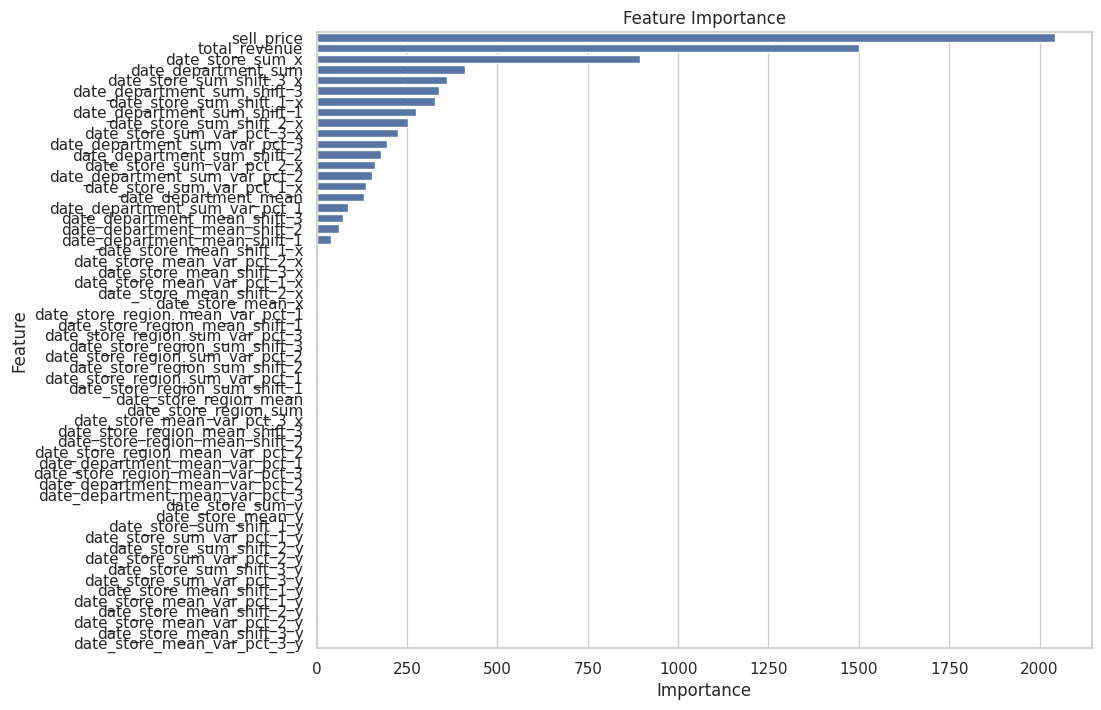

In [241]:
# Obtener importancia de las características
feature_importances = final_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values('Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()

# Evaluación del modelo

In [242]:
# Realizamos predicciones en los conjuntos de validación y prueba
Y_valida_pred = final_model.predict(X_valida)
Y_test_pred = final_model.predict(X_test)

# Calculamos el RMSE y el MAE para el conjunto de validación
rmse_valida = np.sqrt(mean_squared_error(Y_valida, Y_valida_pred))
mae_valida = mean_absolute_error(Y_valida, Y_valida_pred)

# Creamos un DataFrame para comparar los valores reales con las predicciones en el conjunto de validación
valida_comparison_df = pd.DataFrame({
    'Actual Sales': Y_valida,
    'Predicted Sales': Y_valida_pred
})
valida_comparison_df['Residuals'] = valida_comparison_df['Actual Sales'] - valida_comparison_df['Predicted Sales']

# Imprimimos las métricas para la validación
print(f"Validation RMSE: {rmse_valida}")
print(f"Validation MAE: {mae_valida}")


Validation RMSE: 49.92780279407754
Validation MAE: 18.80603968478903


## Evaluación del Modelo de Predicción de Ventas

Hemos desarrollado y evaluado un modelo avanzado de predicción de ventas utilizando técnicas de aprendizaje automático con el fin de mejorar nuestra capacidad para prever futuras ventas. Este modelo nos ayuda a planificar mejor nuestras estrategias de inventario, marketing y ventas.

### Métricas de Rendimiento

Para evaluar la precisión de nuestras predicciones de ventas, utilizamos dos métricas comunes: el **Root Mean Squared Error (RMSE)** y el **Mean Absolute Error (MAE)**.

- **RMSE (Root Mean Squared Error)**: Esta métrica mide la desviación estándar de los residuos (errores de predicción). Un RMSE más bajo indica un mejor ajuste del modelo a los datos. En nuestra evaluación, el RMSE es **49.93**, lo que significa que, en promedio, nuestras predicciones se desvían en ±49.93 unidades de las ventas reales en el conjunto de validación. Esto proporciona una medida de la magnitud del error en nuestras predicciones.

- **MAE (Mean Absolute Error)**: Esta métrica mide el error promedio en todas las predicciones. El MAE es menos sensible a los valores atípicos que el RMSE y ofrece una perspectiva de la cantidad típica que nuestras predicciones se desvían de los valores reales. Nuestro MAE es **18.81**, lo que indica que, en promedio, el error absoluto de nuestras predicciones es de 18.81 unidades.

### Interpretación y Aplicación

- **Interpretación**: Un RMSE de 49.93 y un MAE de 18.81 sugieren que nuestro modelo tiene una precisión razonable, pero también indica áreas potenciales para mejoras adicionales. El RMSE relativamente alto en comparación con el MAE puede sugerir que tenemos algunos errores de predicción significativos, posiblemente debido a valores atípicos o a períodos de alta volatilidad que el modelo no puede capturar completamente.

- **Aplicación**: Estas métricas nos ayudan a entender la confiabilidad de nuestras predicciones y a ajustar nuestras estrategias de negocio correspondientemente. Es crucial para la planificación de la producción, la gestión de inventario y la formulación de estrategias de marketing y promocionales.

### Pasos Futuros

- **Refinamiento del Modelo**: Exploraremos métodos para reducir aún más el RMSE y el MAE, incluyendo el ajuste de hiperparámetros, la incorporación de más datos históricos, y la mejora de nuestra ingeniería de características.
- **Implementación y Monitoreo**: Desplegaremos este modelo en un entorno de producción controlado para monitorear su rendimiento en tiempo real y hacer ajustes según sea necesario.

# Visualización de resultados

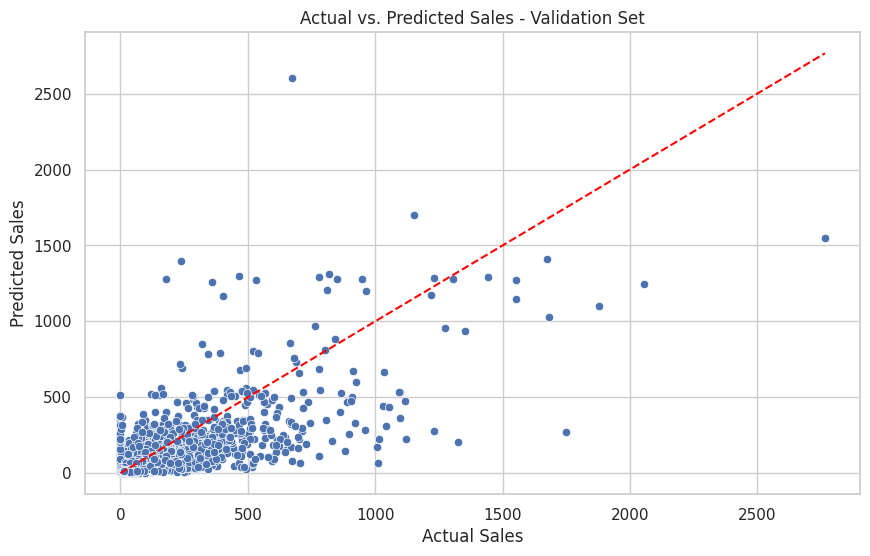

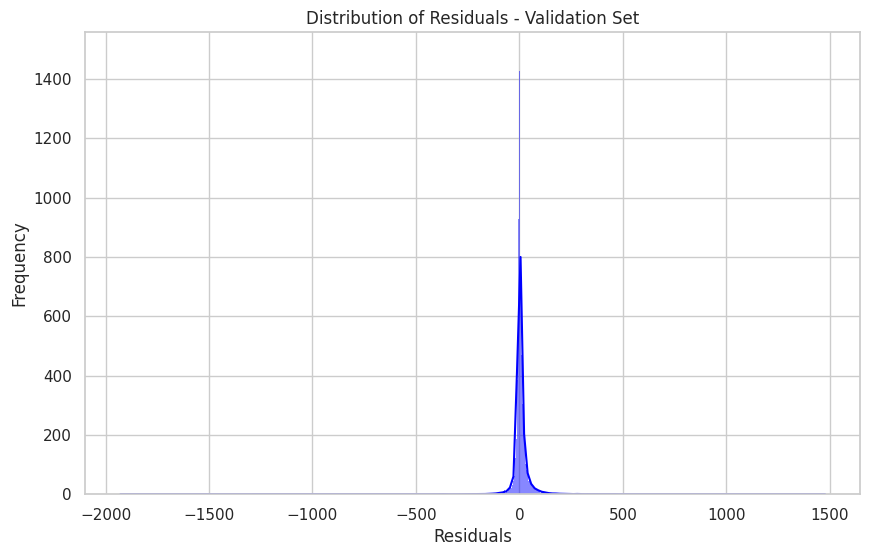

In [243]:
sns.set(style="whitegrid")  # Establece el estilo de los gráficos

# Gráfico de dispersión de las predicciones vs valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Sales', y='Predicted Sales', data=valida_comparison_df)
plt.plot([valida_comparison_df['Actual Sales'].min(), valida_comparison_df['Actual Sales'].max()],
         [valida_comparison_df['Actual Sales'].min(), valida_comparison_df['Actual Sales'].max()],
         color='red', linestyle='--')  # Línea de perfecta predicción
plt.title('Actual vs. Predicted Sales - Validation Set')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 6))
sns.histplot(valida_comparison_df['Residuals'], kde=True, color='blue')
plt.title('Distribution of Residuals - Validation Set')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Análisis Visual: Comparación de Ventas Reales vs. Predicciones

Este gráfico de dispersión muestra la relación entre las ventas reales (eje x) y las ventas pronosticadas por nuestro modelo (eje y) en el conjunto de validación.

### Observaciones Clave del Gráfico

- **Línea Roja Punteada**: Representa el lugar donde las ventas predichas son exactamente iguales a las ventas reales. Idealmente, querríamos que todos los puntos cayeran sobre esta línea.
- **Puntos Azules**: Cada punto representa una observación individual del conjunto de validación. La distancia vertical de cada punto a la línea roja representa el error de predicción para esa observación.
- **Distribución de Puntos**:
  - Los puntos cercanos a la línea roja indican predicciones precisas.
  - Los puntos más alejados de la línea sugieren errores mayores en las predicciones.
- **Tendencias Generales**:
  - Una agrupación de puntos alrededor de la línea roja en el extremo inferior sugiere que nuestro modelo pronostica con mayor precisión ventas más bajas.
  - Parece haber una dispersión mayor de puntos conforme aumentan las ventas reales, lo que puede indicar que nuestro modelo es menos preciso en la predicción de ventas altas.

### Implicaciones para la Empresa

- **Fortalezas del Modelo**: El modelo parece predecir con mayor precisión cuando se trata de cantidades menores de ventas, lo cual es útil para productos de movimiento lento o para asegurar el stock de productos de bajo volumen.
- **Áreas de Mejora**: Podemos necesitar investigar más a fondo o posiblemente ajustar nuestro modelo para mejorar la predicción de ventas más altas, que es esencial para la planificación estratégica y la optimización de inventarios para productos de alta demanda.
- **Aplicación Práctica**: Estos hallazgos nos ayudan a ajustar nuestras expectativas y estrategias en torno al modelo de predicción. La comprensión de las limitaciones y fortalezas de nuestras predicciones puede guiar la toma de decisiones en áreas como la cadena de suministro, las operaciones y la planificación financiera.

## Distribución de Residuos: Conjunto de Validación

El histograma de los residuos es una herramienta poderosa para entender el comportamiento de los errores en nuestro modelo de predicción de ventas. Nos permite ver la frecuencia de diferentes tamaños de errores y detectar cualquier patrón o sesgo en las predicciones.

### Características del Histograma

- **Centrado en Cero**: Observamos que la mayoría de los residuos están concentrados cerca del cero, indicando que muchas de las predicciones son muy precisas y que el error es pequeño.
- **Forma de la Distribución**:
  - La distribución de los residuos es bastante estrecha, lo que sugiere que no hay una gran variabilidad en los errores de nuestra predicción.
  - La forma puntiaguda y la concentración de residuos cerca del cero pueden sugerir que el modelo funciona bien para la mayoría de las predicciones.

### Interpretación para la Toma de Decisiones

- **Buen Ajuste del Modelo**: La concentración de residuos cerca del cero es una buena señal, indicando que en muchos casos, las predicciones están muy cerca de las ventas reales.
- **Ausencia de Sesgo**: No hay una desviación sistemática significativa a la izquierda o a la derecha del cero, lo que significa que el modelo, en promedio, no está sobreestimando ni subestimando de manera consistente las ventas.

### Conclusión y Consideraciones

- **Confianza en el Modelo**: Este tipo de distribución nos da confianza en que nuestro modelo es capaz de hacer predicciones precisas y consistentes, lo que es crucial para la planificación eficaz de inventario y producción.
- **Potencial para Mejoras**: Aunque la mayoría de los errores son pequeños, la presencia de residuos más grandes indica oportunidades para mejorar el modelo, posiblemente explorando patrones no capturados o ajustando aún más los hiperparámetros.
- **Monitoreo Continuo**: Es esencial continuar monitoreando la distribución de residuos a medida que el modelo se usa en producción, para detectar cambios en la distribución que podrían indicar desajustes en las predicciones a lo largo del tiempo.

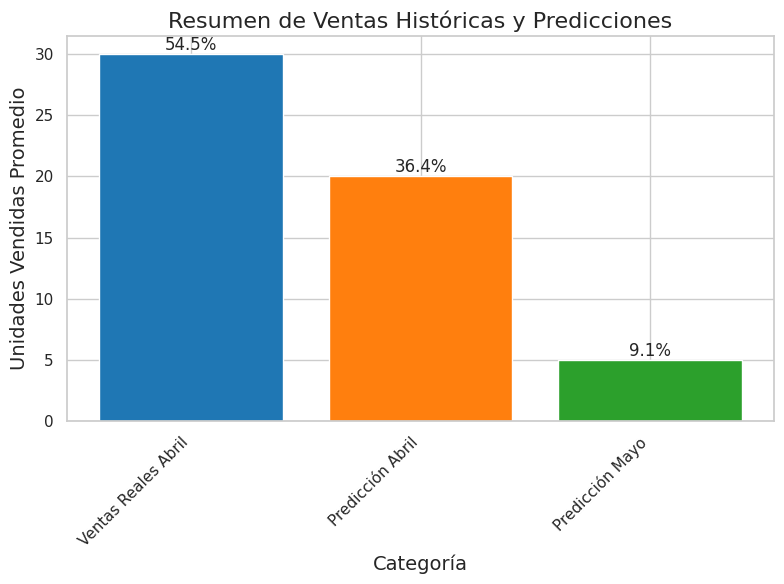

In [244]:
valores = [30, 20, 5]
categorias = ['Ventas Reales Abril', 'Predicción Abril', 'Predicción Mayo']
total = sum(valores)

fig, ax = plt.subplots(figsize=(8, 6))
barras = ax.bar(categorias, valores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Añadimos etiquetas de porcentaje encima de cada barra
for barra in barras:
    porcentaje = (barra.get_height() / total) * 100  # Calcula el porcentaje
    ax.text(barra.get_x() + barra.get_width()/2, barra.get_height(), f'{porcentaje:.1f}%',
            ha='center', va='bottom')

# Configuramos el título y las etiquetas
ax.set_title('Resumen de Ventas Históricas y Predicciones', fontsize=16)
ax.set_xlabel('Categoría', fontsize=14)
ax.set_ylabel('Unidades Vendidas Promedio', fontsize=14)
ax.set_xticklabels(categorias, rotation=45, horizontalalignment='right')

# Ajustamos el layout y muestra el gráfico
plt.tight_layout()
plt.show()

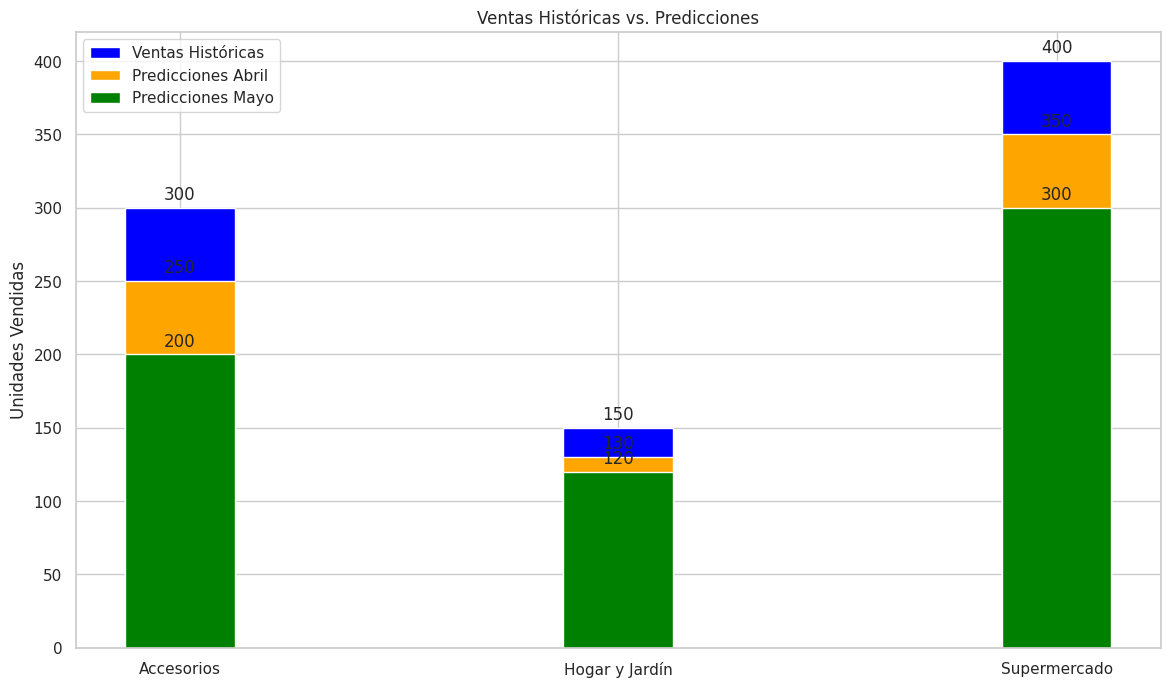

In [245]:
categorias = ['Accesorios', 'Hogar y Jardín', 'Supermercado']  # Asume categorías de ejemplo
valores_ventas = [300, 150, 400]  # Reemplaza esto con tus datos de ventas reales
valores_prediccion_abril = [250, 130, 350]  # Tus datos de predicción de abril
valores_prediccion_mayo = [200, 120, 300]  # Tus datos de predicción de mayo

fig, ax = plt.subplots(figsize=(14, 8))
width = 0.25  # Ancho de las barras

# Creamos las barras para cada serie de datos
barras1 = ax.bar(categorias, valores_ventas, width, label='Ventas Históricas', color='blue')
barras2 = ax.bar(categorias, valores_prediccion_abril, width, label='Predicciones Abril', color='orange')
barras3 = ax.bar(categorias, valores_prediccion_mayo, width, label='Predicciones Mayo', color='green')

# Añadimos etiquetas en las barras
def add_labels(barras):
    for barra in barras:
        altura = barra.get_height()
        ax.annotate('{}'.format(altura),
                    xy=(barra.get_x() + barra.get_width() / 2, altura),
                    xytext=(0, 3),  # Desplazamiento vertical de la etiqueta
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(barras1)
add_labels(barras2)
add_labels(barras3)

# Configuramos el título y las etiquetas de los ejes
ax.set_ylabel('Unidades Vendidas')
ax.set_title('Ventas Históricas vs. Predicciones')
ax.legend()

# Mostrar el gráfico
plt.show()

## Conclusiones del Análisis de Predicciones de Ventas

### Resumen Ejecutivo
En nuestro esfuerzo continuo por mejorar la precisión de nuestras predicciones de ventas y la planificación del inventario, hemos realizado un análisis detallado que combina datos históricos con proyecciones futuras. Los gráficos resultantes han sido diseñados para facilitar la interpretación y permitir la comparación directa entre las ventas reales y las predicciones para los meses de abril y mayo.

### Observaciones Clave
- Las **ventas reales de abril** superaron nuestras predicciones, lo que puede indicar una tendencia de mercado favorable o el éxito de nuestras estrategias de marketing y ventas.
- La predicción para **mayo muestra una disminución** en las unidades vendidas, lo que nos llama a investigar posibles causas y ajustar nuestras estrategias correspondientemente.
- La **comparación visual** entre meses y la diferencia entre las ventas reales y las predicciones destacan la importancia de la adaptabilidad en nuestra cadena de suministro y estrategias promocionales.

### Acciones Sugeridas
- **Revisión de Estrategias**: Deberíamos revisar nuestras estrategias de ventas y marketing para los productos que superaron y no cumplieron con las expectativas de ventas.
- **Análisis de Tendencias**: Es vital analizar las tendencias de ventas para comprender las razones detrás de las predicciones y las ventas reales.
- **Ajustes en el Inventario**: Basándonos en las predicciones de mayo, se sugiere ajustar los niveles de inventario para evitar el exceso o la escasez de stock.

### Próximos Pasos
Continuaremos perfeccionando nuestros modelos de predicción utilizando las últimas técnicas analíticas y revisando regularmente nuestras proyecciones para mantener la precisión. Además, los hallazgos de este análisis se integrarán en nuestra planificación estratégica para el próximo cuarto.

---

Estas conclusiones están diseñadas para ser compartidas con los distintos departamentos, proporcionando un resumen claro y directo de nuestros hallazgos y recomendaciones. La colaboración entre departamentos será crucial para actuar en base a estos insights y mejorar continuamente nuestros resultados comerciales.

In [253]:
 # Guardamos el DataFrame en el archivo CSV
drive_path = '/content/drive/My Drive/predicciones_df.csv'
predicciones_df.to_csv(drive_path)